# Get HOG and color histgram features


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import sklearn
from sklearn.model_selection import train_test_split
import os
from collections import deque
from sklearn.externals import joblib
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features    
    
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, hist_bins=32,bins_range=(0, 1)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        # Read in each one by one
        #image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        
        
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)    
        hist_features = color_hist(feature_image, nbins=hist_bins,bins_range=(0, 1))    
       

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((hog_features, hist_features)))
    # Return list of feature vectors
    return features

def load_images(glob_path):

    images = []
    files = []
    for f in glob.glob(glob_path):
        img = mpimg.imread(f)
        images.append(img)
        files.append(f)

    return np.array(images), np.array(files)





def load_car_not_car_images(root_path='D:/learning/udacity/CarND/term1/data/final_data',
                            non_vehicle_sub_dirs=['Extras', 'GTI'],
                            vehicle_sub_dirs=['GTI_Far', 'GTI_Left',
                                              'GTI_MiddleClose', 'GTI_Right',
                                              'KITTI_extracted']):
    non_vehicle_paths = [root_path + '/non-vehicles/' + p
                         for p in non_vehicle_sub_dirs]
    vehicle_paths = [root_path + '/vehicles/' + p
                     for p in vehicle_sub_dirs]

    def images_from_path(path):
        images, files = load_images(glob_path=path + '/*.png')
        print(path, images.shape, len(files))
        return images

    non_vehicle_images = np.concatenate([images_from_path(p)
                                         for p in non_vehicle_paths], axis=0)
    vehicle_images = np.concatenate([images_from_path(p)
                                     for p in vehicle_paths], axis=0)

    return vehicle_images, non_vehicle_images

In [2]:
car_images, not_car_images = load_car_not_car_images()

D:/learning/udacity/CarND/term1/data/final_data/non-vehicles/Extras (5068, 64, 64, 3) 5068
D:/learning/udacity/CarND/term1/data/final_data/non-vehicles/GTI (3900, 64, 64, 3) 3900
D:/learning/udacity/CarND/term1/data/final_data/vehicles/GTI_Far (834, 64, 64, 3) 834
D:/learning/udacity/CarND/term1/data/final_data/vehicles/GTI_Left (909, 64, 64, 3) 909
D:/learning/udacity/CarND/term1/data/final_data/vehicles/GTI_MiddleClose (419, 64, 64, 3) 419
D:/learning/udacity/CarND/term1/data/final_data/vehicles/GTI_Right (664, 64, 64, 3) 664
D:/learning/udacity/CarND/term1/data/final_data/vehicles/KITTI_extracted (5966, 64, 64, 3) 5966


In [3]:
sample_size = 500
cars_sample = car_images[0:sample_size]
notcars_sample =  not_car_images[0:sample_size]

In [4]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 32
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(not_car_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

127.1 Seconds to extract HOG features...


# Split and normalize data

In [5]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
global X_scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)


# Train the classifier

In [6]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

t=time.time()

global clf2

clf2 = sklearn.svm.SVC(kernel='rbf',C=10)
clf2.fit(X_train, y_train)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

Using: 32 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 3552
100.26 Seconds to train SVC...


In [7]:
# Check the score of the SVC
print('Test Accuracy of clf = ', round(clf2.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf2.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


Test Accuracy of clf =  0.9916
My SVC predicts:  [ 1.  0.  1.  0.  1.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  0.  1.  1.  1.  1.]
0.07821 Seconds to predict 10 labels with SVC


# Sliding Window Search and heat map

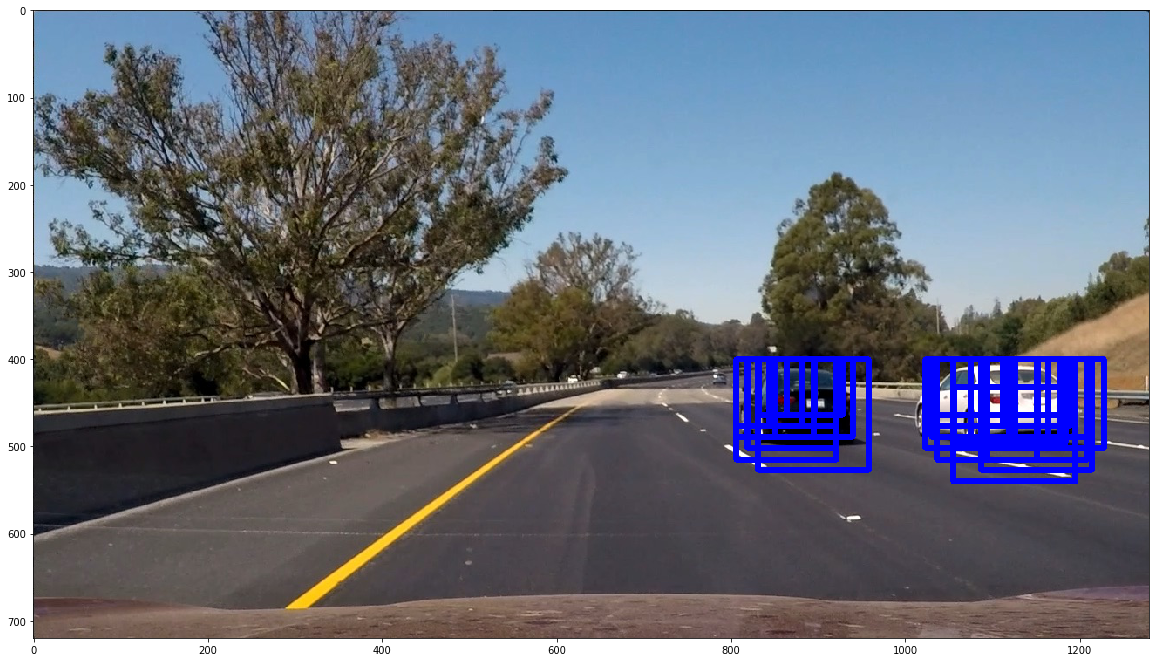

In [68]:
test_images = glob.glob('test_images/*.jpg')
test_image = mpimg.imread(test_images[5])

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale_step, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    bboxes = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch_origin = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    for scale in list(np.arange(1, 3, scale_step)):


        imshape = ctrans_tosearch_origin.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch_origin, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]


        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
        nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
        nfeat_per_block = orient*cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)


        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                #spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=32, bins_range=(0, 1))

                # Scale features and make a prediction
                #test_features = X_scaler.transform(hog_features.reshape(1, -1))    
                test_features = X_scaler.transform(np.hstack((hog_features, hist_features)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    bboxes.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
    return draw_img,bboxes
    
ystart = 400
ystop = 656
scale_step= 0.2

    
out_img, bbox_list = find_cars(test_image, ystart, ystop, scale_step, clf2, X_scaler, orient, pix_per_cell, cell_per_block)

plt.figure(figsize=(20,16))
plt.imshow(out_img)

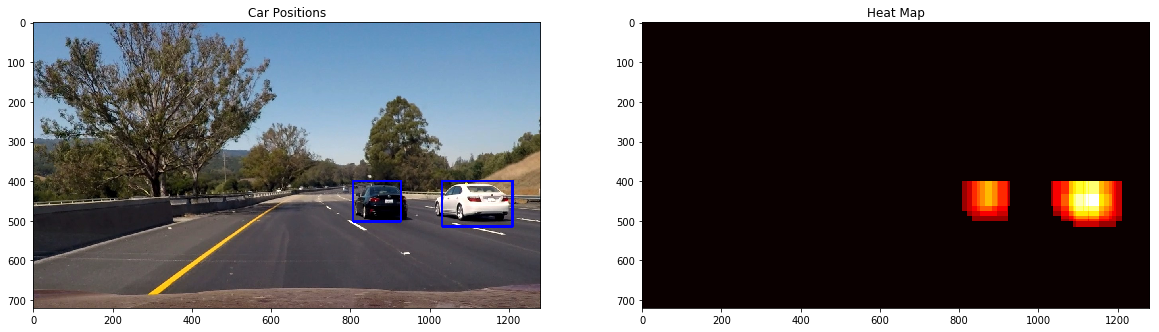

In [69]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat = np.zeros_like(test_image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,bbox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

plt.figure(figsize=(20,16))

plt.subplot(1,2,1)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(1,2,2)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')



# Advanced Lane Detection Part


In [9]:
#*****************************************************************************************************************
#************************************************ Camera calibration**********************************************
#*****************************************************************************************************************

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('D:/learning/udacity/CarND/term1/CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

#set this variables to be global variable since we need it in our image processer
global mtx, img_size, dist

img_size = (1280, 720)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

#*****************************************************************************************************************
#************************************************ Color and gradient threshold************************************
#*****************************************************************************************************************

def hls_color_thresh(img, threshLow, threshHigh):
    imgHLS = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    binary_output = np.zeros((img.shape[0], img.shape[1]))
    binary_output[(imgHLS[:,:,0] >= threshLow[0]) & (imgHLS[:,:,0] <= threshHigh[0]) & (imgHLS[:,:,1] >= threshLow[1])  & (imgHLS[:,:,1] <= threshHigh[1])  & (imgHLS[:,:,2] >= threshLow[2]) & (imgHLS[:,:,2] <= threshHigh[2])] = 1
                 
    return binary_output

def sobel_x(img, sobel_kernel=3,min_thres = 20, max_thres =100):
    imghsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    sobelx1 = cv2.Sobel(imghsl[:,:,1], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobelx2 = cv2.Sobel(imghsl[:,:,2], cv2.CV_64F, 1,0, ksize=sobel_kernel)
    scaled_sobelx1 = np.uint8(255*sobelx1/ np.max(sobelx1))
    scaled_sobelx2 = np.uint8(255*sobelx2/ np.max(sobelx2))
    binary_outputx1 = np.zeros_like(scaled_sobelx1)
    binary_outputx1[(scaled_sobelx1 >= min_thres) & (scaled_sobelx1 <= max_thres)] = 1
    binary_outputx2 = np.zeros_like(scaled_sobelx2)
    binary_outputx2[(scaled_sobelx2 >= min_thres) & (scaled_sobelx2 <= max_thres)] = 1
    binary_output = np.zeros_like(scaled_sobelx1)
    binary_output[(binary_outputx1 ==1) | (binary_outputx2 ==1)]=1
    return binary_output


#*****************************************************************************************************************
#************************************************ Crop the image**************************************************
#*****************************************************************************************************************
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 1)
    
    #returning the image only where mask pixels are nonzero
    cropped = np.zeros_like(img)
    cropped[((img == 1) & (mask == 1))] = 1

    return cropped

#*****************************************************************************************************************
#***************************************** Perspective Transformation*********************************************
#*****************************************************************************************************************
src = np.float32([[585, 450], [205, 720], [1100, 720], [695, 450]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

global M, Minv
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)



#*****************************************************************************************************************
#***************************************** Detect the lane *******************************************************
#*****************************************************************************************************************

def detect_lines_sliding_window(warped_binary):
    # Assuming you have created a warped binary image called "warped_binary"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped_binary.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary.shape[0] - (window+1)*window_height
        win_y_high = warped_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
        left_fit_cr=[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    
    if len(rightx) == 0:
        right_fit =[]
        right_fit_cr=[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    return left_fit, right_fit, left_fit_cr, right_fit_cr
    
def detect_lines(warped_binary, left_fit, right_fit):
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_updated =[]
        left_fit_cr_updated =[]
    else:
        left_fit_updated = np.polyfit(lefty, leftx, 2)
        left_fit_cr_updated = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    
    
    if len(rightx) == 0:
        right_fit_updated =[]
        right_fit_cr_updated =[]
    else:
        right_fit_updated = np.polyfit(righty, rightx, 2)
        right_fit_cr_updated = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
    return  left_fit_updated, right_fit_updated,left_fit_cr_updated,right_fit_cr_updated


#Calc Curvature
def curvature(left_fit, right_fit,left_fit_cr, right_fit_cr, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension


    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    center = (((left_fit[0]*720**2+left_fit[1]*720+left_fit[2]) +(right_fit[0]*720**2+right_fit[1]*720+right_fit[2]) ) /2 - 640)*xm_per_pix

    return left_curverad, right_curverad, center




def drawLine(undist, warped,left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 
    

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))


    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return(result, color_warp)


#*****************************************************************************************************************
#********************************************* fit check ************************************&********************
#*****************************************************************************************************************
def fit_check(left_fit, right_fit):      
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False        
    else:
        status = True
                    
    return status

# Processor

In [70]:
global counter,pre_left,pre_right,left_fit,right_fit
counter=0
pre_left =np.array([0,0,0])
pre_right=np.array([0,0,0])
left_fit =np.array([0,0,0])
right_fit=np.array([0,0,0]) 


def process_image(image):
    #1. Camera correction
    global counter
    global pre_left 
    global pre_right
    global left_fit
    global right_fit
    
    global pre_left_cr 
    global pre_right_cr
    global left_fit_cr
    global right_fit_cr

    img_undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    #2. Threshold color    
    yellow_low = np.array([0,100,100])
    yellow_high = np.array([50,255,255])
    white_low = np.array([18,0,180])
    white_high = np.array([255,80,255])
    

    imgThres_yellow = hls_color_thresh(img_undist,yellow_low,yellow_high)
    imgThres_white = hls_color_thresh(img_undist,white_low,white_high)
    imgThr_sobelx = sobel_x(img_undist,9,80,220) #Sobel x

    img_thr_combined =np.zeros_like(imgThres_yellow)
    img_thr_combined[(imgThres_yellow==1) | (imgThres_white==1) | (imgThr_sobelx==1)] =1
    
    #3. Crop the image
    top=image.shape[0]*0.5
    left = image.shape[1]*.45
    right = image.shape[1]*.55
    vertices = np.array([[(0,image.shape[0]),(left, top), (right, top), (image.shape[1],image.shape[0])]], dtype=np.int32)    
    masked = region_of_interest(img_thr_combined,vertices)
    
    #4. Perspective transformation
    img_size = (masked.shape[1], masked.shape[0])
    binary_warped = cv2.warpPerspective(masked, M, img_size, flags=cv2.INTER_LINEAR)
    
    #5. Detect lanes and return fit curves    
    if counter==0:
        left_fit, right_fit,left_fit_cr,right_fit_cr = detect_lines_sliding_window(binary_warped)
    else:
        left_fit, right_fit,left_fit_cr,right_fit_cr = detect_lines(binary_warped, left_fit, right_fit)
    
    
    #6. fit check
    status_fit=fit_check(left_fit, right_fit)
    
    
    #7. Calculate curvature and center
    if status_fit  == True:        
        pre_left, pre_right = left_fit, right_fit
        pre_left_cr, pre_right_cr = left_fit_cr, right_fit_cr
        counter+=1
    else:        
        left_fit, right_fit = pre_left, pre_right
        left_fit_cr, right_fit_cr = pre_left_cr, pre_right_cr
        
    left_curv, right_curv, center_off = curvature(left_fit, right_fit,left_fit_cr, right_fit_cr, binary_warped)

    #8. Draw image   
    img_out, img_birds = drawLine(img_undist, binary_warped,left_fit, right_fit)

    
    #Write curvature and center in image
    TextL = "Left Curv: " + str(int(left_curv)) + " m"
    TextR = "Right Curv: " + str(int(right_curv))+ " m"
    TextC = "Center Offset: " + str(round( center_off,2)) + "m"
    
    fontScale=1
    thickness=2
    
    fontFace = cv2.FONT_HERSHEY_SIMPLEX


    cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextC, (130,100), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
   
    #*****************************************Next do vehicle detection******************************************
    orient = 32
    pix_per_cell = 16
    cell_per_block = 2
    scale_step = 0.2
    _, bbox_list = find_cars(img_undist, ystart, ystop, scale_step, clf2, X_scaler, orient, pix_per_cell, cell_per_block)
    
    heat = np.zeros_like(img_undist[:,:,0]).astype(np.float)

# Add heat to each box in box list
    heat = add_heat(heat,bbox_list)
    
# Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img_out), labels)

    
    return draw_img

In [72]:
video_output = 'test_videos_output\\project_video_color.mp4'

##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

in_clip = VideoFileClip("project_video.mp4")

video_clip = in_clip.fl_image(process_image) #NOTE: this function expects color images!!

%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output\project_video_color.mp4
[MoviePy] Writing video test_videos_output\project_video_color.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [5:14:33<00:14, 14.61s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output\project_video_color.mp4 

Wall time: 5h 14min 33s
